# 电力窃漏电用户自动识别

## 拉格朗日插值法

In [1]:
import pandas as pd
from scipy.interpolate import lagrange

In [2]:
input_file = './data/missing_data.xls'

In [3]:
data = pd.read_excel(input_file, header=None)

In [4]:
data # 预览原始数据

,0,1,2
0,235.8333,324.0343,478.3231
1,236.2708,325.6379,515.4564
2,238.0521,328.0897,517.0909
3,235.9063,NaN,514.8900
4,236.7604,268.8324,NaN
5,NaN,404.0480,486.0912
6,237.4167,391.2652,516.2330
7,238.6563,380.8241,NaN
8,237.6042,388.0230,435.3508
9,238.0313,206.4349,487.6750


In [5]:
def plotinterp_column(s, n, k=5): # s 是 Series，n 是对应数据的 index，k 是插值范围
    y = s[list(range(n-k, n)) + list(range(n+1, n+1+k))]   # 取当前数据的前后5个数据
    y = y[y.notnull()]  # 取出数据中的非空值
    return lagrange(y.index, list(y))(n) 

In [6]:
for i in data.columns:
    col_na = data[i].isna()
    for j in range(len(data)):
        if col_na[j]:
            data[i][j] = plotinterp_column(data[i], j)

/Users/onionkev/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


In [7]:
data # 插值后的数据

,0,1,2
0,235.833300,324.034300,478.323100
1,236.270800,325.637900,515.456400
2,238.052100,328.089700,517.090900
3,235.906300,203.462116,514.890000
4,236.760400,268.832400,493.352591
5,237.151181,404.048000,486.091200
6,237.416700,391.265200,516.233000
7,238.656300,380.824100,493.342382
8,237.604200,388.023000,435.350800
9,238.031300,206.434900,487.675000


这部分只是重新温习拉格朗日插值法，对接下来的练习并没有实际作用

## 预测模型

### 读取指标数据并设置训练集和测试集

In [8]:
datafile = './data/model.xls'

In [9]:
df_model = pd.read_excel(datafile)

In [10]:
df_model.head()

,电量趋势下降指标,线损指标,告警类指标,是否窃漏电
0,4,1,1,1
1,4,0,4,1
2,2,1,1,1
3,9,0,0,0
4,3,1,0,0


In [11]:
# 随机打乱数据的顺序
idx_lst = list(df_model.index)
pd.np.random.shuffle(idx_lst)

df_model = df_model.iloc[idx_lst]

In [12]:
prop = 0.8  # 设置训练集的比例

In [13]:
train = df_model.iloc[:int(len(df_model)*prop), :]  # 提取训练集
test = df_model.iloc[int(len(df_model)*prop):, :]   # 提取测试集

In [14]:
len(df_model), len(train), len(test)

(291, 232, 59)

### 神经网络预测模型

In [15]:
from keras.models import Sequential
from keras.layers.core import Dense

Using TensorFlow backend.


In [16]:
# 取前三列作为 x，最后一列作为 y 
x_train = train.iloc[:,:3]
y_train = train.iloc[:,3]

In [17]:
x_test = test.iloc[:,:3]
y_test = test.iloc[:,3]

In [18]:
model = Sequential()
model.add(Dense(10, activation='relu', input_dim=3))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.


In [19]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [20]:
model.fit(x_train, y_train, epochs=100, batch_size=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
232/232 [==============================] - 1s 2ms/step - loss: 0.6910 - acc: 0.6466
Epoch 2/100
232/232 [==============================] - 0s 1ms/step - loss: 0.5707 - acc: 0.8276
Epoch 3/100
232/232 [==============================] - 0s 1ms/step - loss: 0.5252 - acc: 0.8621
Epoch 4/100
232/232 [==============================] - 0s 1ms/step - loss: 0.4949 - acc: 0.8621
Epoch 5/100
232/232 [==============================] - 0s 1ms/step - loss: 0.4680 - acc: 0.8621
Epoch 6/100
232/232 [==============================] - 0s 1ms/step - loss: 0.4434 - acc: 0.8621
Epoch 7/100
232/232 [==============================] - 0s 1ms/step - loss: 0.4243 - acc: 0.8621
Epoch 8/100
232/232 [==============================] - 0s 1ms/step - loss: 0.4012 - acc: 0.8621
Epoch 9/100
232/232 [==============================] - 0s 1ms/step - loss: 0.3792 - acc: 0.8664
Epoch 10/100
232/232 [==============================] - 0s 1ms/step - loss: 0.3614 - acc

In [21]:
pred_train = model.predict_classes(x_train); 
pred_test = model.predict_classes(x_test);

#### 预测结果

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [23]:
cm_train = confusion_matrix(pred_train, y_train)
cm_test = confusion_matrix(pred_test, y_test)

In [24]:
def plot_cm(cm):
    plt.matshow(cm, cmap=plt.cm.autumn_r)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.annotate(cm[i,j], xy=(i,j),horizontalalignment='center', verticalalignment='center')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    # plt.yticks([0,1], ['Bad', 'Good'])
    # plt.xticks([0,1], ['Bad', 'Good'])
    plt.show()

In [25]:
model.evaluate(x_train, y_train)

232/232 [==============================] - 0s 219us/step


[0.1506773641911046, 0.9568965517241379]

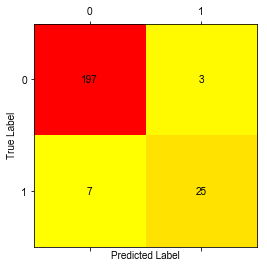

In [26]:
plot_cm(cm_train)

In [27]:
model.evaluate(x_test, y_test)

59/59 [==============================] - 0s 61us/step


[0.30518017886048654, 0.8644067927942438]

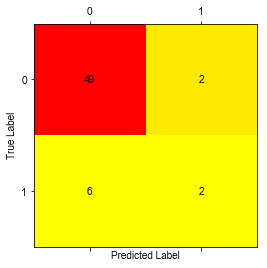

In [28]:
plot_cm(cm_test)

### CART决策树

In [29]:
from sklearn.tree import DecisionTreeClassifier

In [30]:
tree = DecisionTreeClassifier()

In [31]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [73]:
tree.score(x_train, y_train)

0.9698275862068966

In [74]:
tree.score(x_test, y_test)

0.847457627118644

In [32]:
tpred_train = tree.predict(x_train)
tpred_test = tree.predict(x_test)

In [33]:
tcm_train = confusion_matrix(tpred_train, y_train)
tcm_test = confusion_matrix(tpred_test, y_test)

#### 预测结果

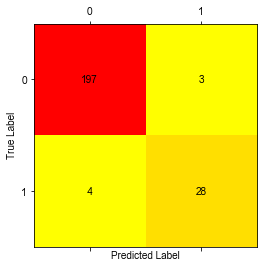

In [34]:
plot_cm(tcm_train)

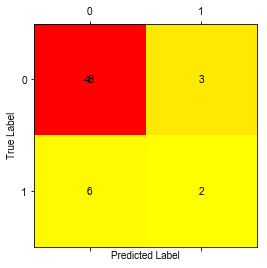

In [35]:
plot_cm(tcm_test)

#### 决策树可视化

In [36]:
from sklearn.tree import export_graphviz
from IPython.display import display
import graphviz
import re

In [37]:
f = export_graphviz(tree, feature_names=x_train.columns, max_depth=2, out_file=None, filled=True,
                  special_characters=True, rotate=True)

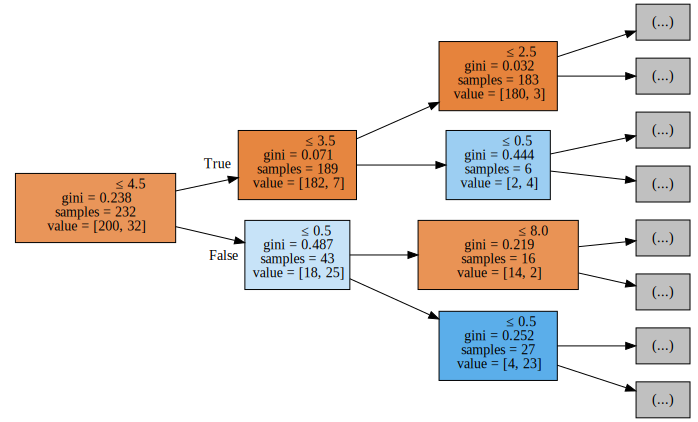

In [38]:
display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size=10; ratio=0.6', f)))

## ROC曲线

In [42]:
from sklearn.metrics import roc_curve

In [56]:
nnpred_test = model.predict(x_test)
tpred_test_p = tree.predict_proba(x_test)[:,1]

In [58]:
def plot_roc(pred, y, name):
    fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1)
    plt.figure(dpi=100)
    plt.plot(fpr, tpr, linewidth=2, label=f'ROC of {name}')
    plt.xlabel('False Positice Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    plt.show()

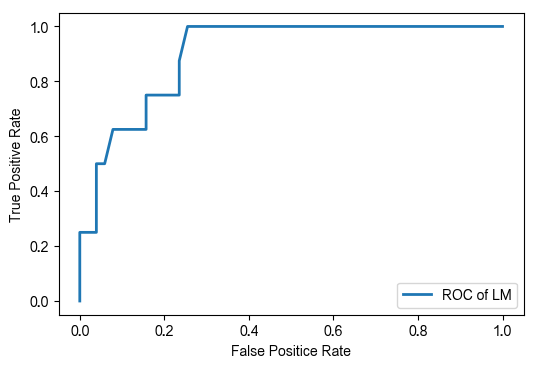

In [59]:
plot_roc(nnpred_test, y_test, 'LM')

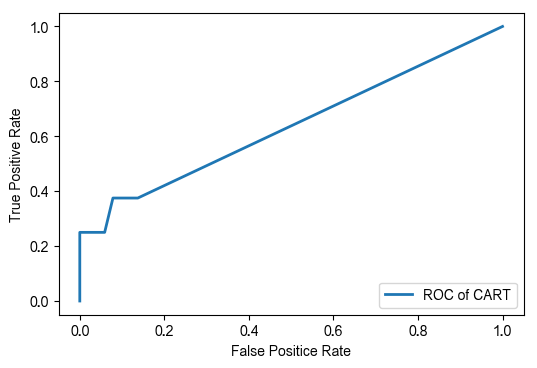

In [60]:
plot_roc(tpred_test_p, y_test, 'CART')